# Sensor Based Activity Recoginition 
Challenge: cdl1 - Sensor based Activity Recognition  
Team: Lea Bütler, Manjavy Kirupa, Etienne Roulet, Si Ben Tran  

Aufgabe: DL Modell erstellen

Hier in diesem Notebook erstellen wir unsere Deep Learning Modelle.

In [1]:
import matplotlib.pyplot
import tensorflow as tf
from sklearn.model_selection import KFold
import numpy as np
import logging
from datetime import datetime
import dataclasses
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection as ms
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import numpy as np

tf.debugging.set_log_device_placement(False)

# datetime as filename for logging
now = datetime.now()
date_time_string = now.strftime("%Y-%m-%d_%H-%M-%S")

logging.basicConfig(
    level=logging.INFO, filename=f"{date_time_string}.txt", filemode="a"
)
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
%pip 


Usage:   
  c:\Users\super\miniconda3\envs\tf_gpu\python.exe -m pip <command> [options]

Commands:
  install                     Install packages.
  download                    Download packages.
  uninstall                   Uninstall packages.
  freeze                      Output installed packages in requirements format.
  inspect                     Inspect the python environment.
  list                        List installed packages.
  show                        Show information about installed packages.
  check                       Verify installed packages have compatible dependencies.
  config                      Manage local and global configuration.
  search                      Search PyPI for packages.
  cache                       Inspect and manage pip's wheel cache.
  index                       Inspect information available from package indexes.
  wheel                       Build wheels from your requirements.
  hash                        Compute hashes of package

# Daten einlesen

In [3]:
from dataclasses import dataclass


# Static Parameters
@dataclass
class Parameters:
    batch_size: int = 64
    epochs: int = 25
    verbosity: str = "auto"
    step_size: int = 1000
    number_folds: int = 6
    output_size: int = 6
    window_size = 400
    step_size = 10
    data_augmentation  = False
    
    

In [4]:
df = pd.read_csv("../Sensor_Data-Wrangling-und-EDA/Alle_Messungen_trimmed.csv")
df.head()

,Unnamed: 0,time,Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,Orientation_qx,Orientation_qy,Orientation_qz,id,user,class,id_combined
0,1,2023-02-27 15:02:17.156,0.000,9.722,1.278,0.0,0.0,0.0,0.000000,0.0,0.000000,-0.21775,-0.719579,0.631111,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
1,2,2023-02-27 15:02:31.574,-0.728,9.779,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,-0.42065,0.568356,-0.598058,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
2,3,2023-02-27 15:02:16.685,0.000,0.000,0.000,0.0,0.0,0.0,0.000000,43.5,-13.143750,0.00000,0.000000,0.000000,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
3,4,2023-02-27 15:02:32.295,0.000,0.000,0.000,0.0,0.0,0.0,-13.012501,0.0,20.587502,0.00000,0.000000,0.000000,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
4,5,2023-02-27 15:02:33.285,0.000,0.000,0.000,0.0,0.0,0.0,-22.612501,0.0,20.268751,0.00000,0.000000,0.000000,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen


## Time umwandeln 

In [5]:
# convert the string time column to datetime
epoch = pd.Timestamp("1970-01-01")

df["time"] = pd.to_datetime(df["time"])
df["time"] = (df["time"] - epoch).apply(lambda x: int(x.total_seconds() * 1000))

print(df.shape)

(2344488, 18)


## Create Validation Data

In [6]:
# select three random id_combines files
ids = ["06_iPhone12-2023-03-16_13-46-58Manjavy_KirupaVelofahren", "01_iPhone13pro-2023-03-21_16-55-47Etienne_RouletLaufen", "01_iPhone13ProMax-2023-03-15_18-29-42Gabriel_TorresRennen"]
df_validation = df[df["id_combined"].isin(ids)]

# export to csv 
df_validation.to_csv("validation-velo-laufen-rennen.csv", index=False)

# remove the validation data from the dataframe 
df = df[~df["id_combined"].isin(ids)]

## Drop unnötige Spalten und Class Encoden

In [7]:
df = df.drop(columns=["id", "user", "id_combined"])
df.drop(["Unnamed: 0"], axis=1, inplace=True)
# get all types of the df
le = LabelEncoder()
df["class"] = le.fit_transform(df["class"])
# print dictionary of the classes and its encoded values
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Laufen': 0, 'Rennen': 1, 'Sitzen': 2, 'Stehen': 3, 'Treppenlaufen': 4, 'Velofahren': 5}


## Daten Transformation

In [8]:
import random
def add_noise(time_series, noise_factor):
    noise = np.random.randn(len(time_series)) * noise_factor
    return time_series + noise

# Flip time series
def flip_time_series(time_series):
    return np.flip(time_series)

# Scale magnitude
def scale_magnitude(time_series, scaling_factor):
    return time_series * scaling_factor

# Augment the data
def augment_data(X, y, noise_factor, scaling_factor, flip_probability):
    augmented_X = []
    augmented_y = []
    for i in range(X.shape[0]):
        x_sample = X[i]
        y_sample = y[i]

        # Add noise
        x_sample_noisy = add_noise(x_sample, noise_factor)
        augmented_X.append(x_sample_noisy)
        augmented_y.append(y_sample)

        # Scale magnitude
        x_sample_scaled = scale_magnitude(x_sample, scaling_factor)
        augmented_X.append(x_sample_scaled)
        augmented_y.append(y_sample)

        # Flip time series
        if random.random() < flip_probability:
            x_sample_flipped = flip_time_series(x_sample)
            augmented_X.append(x_sample_flipped)
            augmented_y.append(y_sample)

    return np.array(augmented_X), np.array(augmented_y)

In [9]:
window_size = Parameters.window_size
step_size = Parameters.step_size

X = df.values[:, 1:13]
y = df["class"].values

X_windows = []
y_windows = []

if Parameters.data_augmentation:
    noise_factor = 0.1
    scaling_factor = 1.5
    flip_probability = 0.5

    # Augment the data
    X_augmented, y_augmented = augment_data(X, y, noise_factor, scaling_factor, flip_probability)
    
    augmented_i = 0
    i = 0
    while augmented_i + window_size <= X_augmented.shape[0]:
        window_data = X_augmented[augmented_i : augmented_i + window_size, :]
        window_labels = y_augmented[augmented_i : augmented_i + window_size]
        
        # Check if there is an activity transition within the window
        if len(np.unique(window_labels)) == 1:
            X_windows.append(window_data)
            y_windows.append(window_labels[0])
            
        augmented_i += step_size
        i += step_size
else:
    i = 0
    while i + window_size <= X.shape[0]:
        window_data = X[i : i + window_size, :]
        window_labels = y[i : i + window_size]
        
        # Check if there is an activity transition within the window
        if len(np.unique(window_labels)) == 1:
            X_windows.append(window_data)
            y_windows.append(window_labels[0])
            
        i += step_size

X_windows = np.array(X_windows)
timesteps = X_windows.shape[1]  # Update timesteps value
n_features = X_windows.shape[2]
X_windows = X_windows.reshape(-1, timesteps, n_features)

y_windows = to_categorical(y_windows, num_classes=6)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_windows, y_windows, test_size=0.2, random_state=42, stratify=y_windows
)


In [10]:
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2306798, 12),
 (2306798,),
 (184352, 400, 12),
 (184352, 6),
 (46088, 400, 12),
 (46088, 6))

## Umschreibung

In [11]:
x_train = X_train
x_validation = X_test
y_train = y_train
y_validation = y_test

# DL-Modelle erstellen

In [12]:
# Something like this as first Model

def create_model_1(name="model_1"):
    model = tf.keras.Sequential(
        [
            # Add a 1D convolutional layer
            tf.keras.layers.Conv1D(
                filters=64,
                kernel_size=12,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            # Add LSTM layer
            tf.keras.layers.LSTM(100),
            # Add a dense output layer
            tf.keras.layers.Dense(
                6, activation="softmax"
            ),  # Change activation function based on the nature of the output
        ],
        name=name,
    )
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model


def create_model_2(name="model_2"):
    model = tf.keras.Sequential(
        [
            # Add a 1D convolutional layer
            tf.keras.layers.Conv1D(
                filters=16,
                kernel_size=4,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            # Add LSTM layer
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
            tf.keras.layers.Dropout(0.2),

            # Add a dense output layer
            tf.keras.layers.Dense(
                6, activation="softmax"
            ),  # Change activation function based on the nature of the output
        ],
        name=name,
    )
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

def create_model_3(name="model_3"):
    model = tf.keras.Sequential(
        [
            # Add a 1D convolutional layer
            tf.keras.layers.Conv1D(
                filters=32,
                kernel_size=2,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            # Add LSTM layer
            tf.keras.layers.LSTM(100),
            # Add a dense output layer
            tf.keras.layers.Dense(
                6, activation="softmax"
            ),  # Change activation function based on the nature of the output
        ],
        name=name,
    )
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model


def create_model_4(name="model_4"):
    model = tf.keras.Sequential(
        [
            # Add a 1D convolutional layer
            tf.keras.layers.Conv1D(
                filters=64,
                kernel_size=2,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            # Add LSTM layer
            tf.keras.layers.LSTM(100),
            # Add a dense output layer
            tf.keras.layers.Dense(
                6, activation="softmax"
            ),  # Change activation function based on the nature of the output
        ],
        name=name,
    )
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model


def create_model_5(name="model_5"):
    model = tf.keras.Sequential(
        [
            # Add a 1D convolutional layer
            tf.keras.layers.Conv1D(
                filters=32,
                kernel_size=2,
                activation="relu",
                padding="same",
                input_shape=(timesteps, n_features),
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(
                filters=20, kernel_size=2, activation="relu", padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            tf.keras.layers.Conv1D(
                filters=10, kernel_size=2, activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            tf.keras.layers.MaxPooling1D(pool_size=2),
            # flatten output
            tf.keras.layers.Flatten(),
            # Add a dense output layer
            tf.keras.layers.Dense(180, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01),),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01),),
            tf.keras.layers.BatchNormalization(),
            # Change activation function based on the nature of the output
            tf.keras.layers.Dense(6, activation="softmax"),
        ],
        name=name,
    )

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model

# DL-Modelle Trainieren

In [13]:
best_model_history = None  # Keep track of the best model's history
model_histories = []

# Perform training and validation
models = [create_model_5]
best_model = None
best_model_acc = 0

for j, model_creator in enumerate(models):
    print(f"Model {model_creator.__name__}")
    model_name = f"Model_{j+1}"
    model = model_creator(name=model_name)
    logging.info(f"Model {j+1}")
    history = model.fit(
        X_train,
        y_train,
        epochs=Parameters.epochs,
        batch_size=Parameters.batch_size,
        validation_data=(x_validation, y_validation),
        verbose=Parameters.verbosity,
    )
    test_loss, acc, prec, recal = model.evaluate(
        x_validation, y_validation, verbose=Parameters.verbosity
    )
    logging.info(f"Validation accuracy: {acc}")

    model_histories.append(history.history)

    for epoch in range(Parameters.epochs):
        # Log accuracy after each epoch
        acc_epoch = history.history["val_accuracy"][epoch]
        logging.info(f"Epoch {epoch + 1}, Validation accuracy: {acc_epoch}")

    if best_model_history is None or acc > best_model_acc:
        best_model_history = history
        best_model = model  # Store the trained model instance
        best_model_acc = acc

print(best_model.name)


Model create_model_5
Epoch 1/25
2881/2881 [==============================] - 34s 10ms/step - loss: 0.9191 - accuracy: 0.9040 - precision: 0.9209 - recall: 0.8892 - val_loss: 0.4032 - val_accuracy: 0.9337 - val_precision: 0.9406 - val_recall: 0.9281
Epoch 2/25
2881/2881 [==============================] - 30s 10ms/step - loss: 0.3306 - accuracy: 0.9485 - precision: 0.9547 - recall: 0.9439 - val_loss: 0.2485 - val_accuracy: 0.9661 - val_precision: 0.9710 - val_recall: 0.9619
Epoch 3/25
2881/2881 [==============================] - 29s 10ms/step - loss: 0.2610 - accuracy: 0.9560 - precision: 0.9619 - recall: 0.9517 - val_loss: 0.2420 - val_accuracy: 0.9536 - val_precision: 0.9600 - val_recall: 0.9501
Epoch 4/25
2881/2881 [==============================] - 29s 10ms/step - loss: 0.2285 - accuracy: 0.9607 - precision: 0.9659 - recall: 0.9570 - val_loss: 0.2151 - val_accuracy: 0.9603 - val_precision: 0.9657 - val_recall: 0.9560
Epoch 5/25
2881/2881 [==============================] - 29s 10ms/st

## Loss und Accuracy Verlauf vom besten Modell

Model_1


[0.903950035572052,
 0.9485440850257874,
 0.9560026526451111,
 0.9606621861457825,
 0.9641392827033997,
 0.9653163552284241,
 0.9677627682685852,
 0.968663215637207,
 0.9696721434593201,
 0.9702905416488647,
 0.970447838306427,
 0.9717605710029602,
 0.9717822670936584,
 0.9728671312332153,
 0.9733010530471802,
 0.9725362062454224,
 0.973534345626831,
 0.9732847809791565,
 0.9719341397285461,
 0.9738814830780029,
 0.9734909534454346,
 0.9739899635314941,
 0.9742449522018433,
 0.974494457244873,
 0.9736482501029968]

[0.9191294312477112, 0.33055001497268677, 0.26098042726516724, 0.22853615880012512, 0.2080216109752655, 0.19936689734458923, 0.18588553369045258, 0.1800595372915268, 0.17563281953334808, 0.17421092092990875, 0.1699569821357727, 0.1684659868478775, 0.16754896938800812, 0.16169272363185883, 0.1596543937921524, 0.15869146585464478, 0.15550497174263, 0.15618054568767548, 0.15668316185474396, 0.15092521905899048, 0.1534535139799118, 0.15086355805397034, 0.15151460468769073, 0.14897096157073975, 0.15220655500888824]


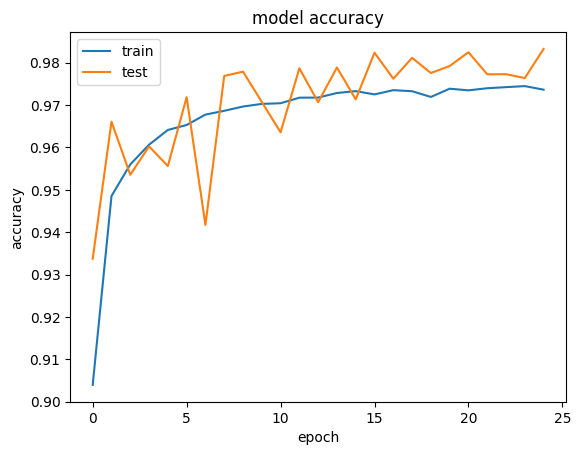

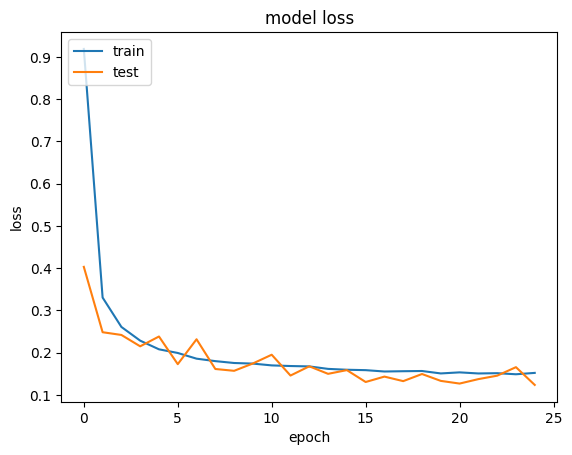

In [14]:
print(best_model.name)
display(best_model_history.history["accuracy"])
print(best_model_history.history["loss"])
# summarize history for accuracy
plt.plot(best_model_history.history["accuracy"])
plt.plot(best_model_history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()
# summarize history for loss
plt.plot(best_model_history.history["loss"])
plt.plot(best_model_history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Confusions Matrix

1441/1441 [==============================] - 3s 2ms/step


array(['Laufen', 'Rennen', 'Sitzen', 'Stehen', 'Treppenlaufen',
       'Velofahren'], dtype=object)

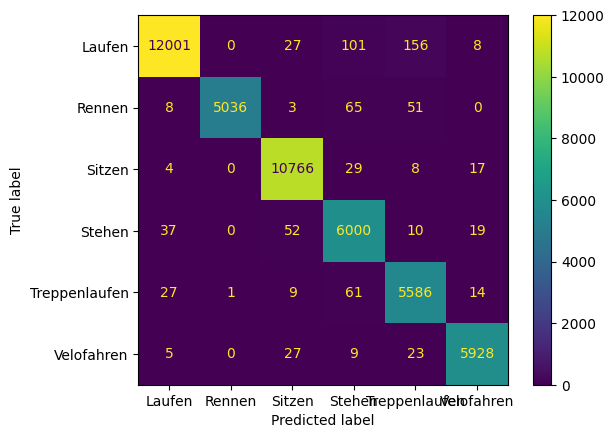

array([0.98469744, 0.98745098, 0.99189239, 0.9690705 , 0.96878252,
       0.98981466])

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# for multiclass classification
y_pred = best_model.predict(x_validation)
y_test_labels = y_validation.argmax(axis=1)
y_pred_labels = y_pred.argmax(axis=1)

# create cm
cm = confusion_matrix(y_test_labels, y_pred_labels)
display(le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
# get f1 score of each class
from sklearn.metrics import f1_score

f1 = f1_score(y_test_labels, y_pred_labels, average=None)
# get f1 score of each class

# plot confusion matrix
disp.plot()
plt.show()
display(f1)

## Validation Daten Predicten

# Export bestes DL-Modell

In [16]:
# export Model to json Tensorflow file
import json

best_model.save("saved_model/sensor_model.h5")

model = tf.keras.models.load_model("saved_model/sensor_model.h5")

# Save model architecture to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to a JSON file
weights = model.get_weights()
weights_as_list = [w.tolist() for w in weights]
with open("weights.json", "w") as f:
    json.dump(weights_as_list, f)

# Modell Einlesen und predicten

In [17]:

class validate_unseen_data():
    def __init__(self, model_path="saved_model/sensor_model.h5"):
        self.model = tf.keras.models.load_model(model_path)
        self.csv_path = "validation-velo-laufen-rennen.csv"
        
    def predict_classes(self, file="06_iPhone12-2023-03-16_13-46-58Manjavy_KirupaVelofahren", expected=''):
        df_val = pd.read_csv(self.csv_path)
        # Filter the rows where its velo in id_combined
        df_val = df_val[df_val["id_combined"].str.contains(file)]
        df_val = df_val.drop(columns=["id", "user", "id_combined"])
        # convert the string time column to datetime
        epoch = pd.Timestamp("1970-01-01")
        df_val["time"] = pd.to_datetime(df_val["time"])
        df_val["time"] = (df_val["time"] - epoch).apply(
            lambda x: int(x.total_seconds() * 1000)
        )
        df_val.drop(["Unnamed: 0"], axis=1, inplace=True)
        # get all types of the df
        le = LabelEncoder()
        df_val["class"] = le.fit_transform(df_val["class"])

        # Set the window size and step size
        window_size = 400
        step_size = 100

        # Reshape X to 2D format (samples, features)
        X = df_val.values[:, 1:13]

        # Create a sliding window of X with the specified window and step sizes
        X_windows = np.array(
            [
                X[i : i + window_size, :]
                for i in range(0, X.shape[0] - window_size + 1, step_size)
            ]
        )

        # Reshape X_windows to 3D format (samples, timesteps, features)
        timesteps = X_windows.shape[1]
        n_features = X_windows.shape[2]
        X_windows = X_windows.reshape(-1, timesteps, n_features)

        y_pred_probs = model.predict(X_windows)

        # Get the predicted class labels for each input window
        y_pred_labels = np.argmax(y_pred_probs, axis=1)

        # Print the predicted class labels
        # get the median of the predicted labels
        sol = np.median(y_pred_labels)

        class_counts = np.bincount(y_pred_labels)
        for i, count in enumerate(class_counts):
            print(f"Class {i} count: {count}")
        
        return (sol, expected)

median = validate_unseen_data().predict_classes('06_iPhone12-2023-03-16_13-46-58Manjavy_KirupaVelofahren', expected='velo')
median2 = validate_unseen_data().predict_classes('01_iPhone13ProMax-2023-03-15_18-29-42Gabriel_TorresRennen', expected='rennen')
median3 = validate_unseen_data().predict_classes('01_iPhone13pro-2023-03-21_16-55-47Etienne_RouletLaufen', expected='laufen')

(median, median2, median3)



2/2 [==============================] - 0s 193ms/step
Class 0 count: 0
Class 1 count: 0
Class 2 count: 0
Class 3 count: 0
Class 4 count: 0
Class 5 count: 55
8/8 [==============================] - 0s 2ms/step
Class 0 count: 0
Class 1 count: 223
Class 2 count: 1
Class 3 count: 5
Class 4 count: 18
2/2 [==============================] - 0s 4ms/step
Class 0 count: 50
Class 1 count: 0
Class 2 count: 0
Class 3 count: 0
Class 4 count: 14


((5.0, 'velo'), (1.0, 'rennen'), (0.0, 'laufen'))

In [18]:
# the Conclusion is that the model is not overfitted but Gabriel is more a Stepper than a Runner ;)